## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализуем значения пикселей
x_train = x_train / 255
x_test = x_test / 255

# Преобразуем целочисленные пиксели к типа float32
# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, num_features])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, num_features])

# Делаем данные категориальными
y_train = to_categorical(y_train, 10)

# Перемешаем тренировочные данные
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=5000).batch(batch_size)

In [7]:
# Создадим нейронную сеть
class DenseNN(tf.Module):
    def __init__(self, outputs, activate="relu"):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b, trainable=False)

            self.fl_init = True

        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)

        return y


class SequentialModule(tf.Module):
    def __init__(self):
        super().__init__()
       # Первый слой, состоящий из 128 нейронов
       # Место для вашего кода
        self.layer_1 = DenseNN(128)
       # Второй слой, состоящий из 256 нейронов
       # Место для вашего кода
        self.layer_2 = DenseNN(256)
       # Выходной слой
       # Место для вашего кода
        self.layer_3 = DenseNN(10, activate="softmax")

    def __call__(self, x):
      y = self.layer_1(x)
      y = self.layer_2(y)
      y = self.layer_3(y)
      return y

In [8]:
from tensorflow.keras.metrics import Accuracy


# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    acc = Accuracy()
    acc.update_state(y_pred, y_true)
    return acc.result().numpy()

In [9]:
model = SequentialModule()
# Функция обучения нейросети
opt = tf.optimizers.SGD(learning_rate=0.001)

@tf.function
def train_batch(x_batch, y_batch):
  with tf.GradientTape() as tape:
    f_loss = cross_entropy(y_batch, model(x_batch))

  grads = tape.gradient(f_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))

  return f_loss

In [13]:
# Тренировка сети
loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети
x_for_plot = []
for epoch in range(training_steps):
    loss = 0
    for x_batch, y_batch in train_dataset:
        loss += train_batch(x_batch, y_batch)
    if epoch % display_step == 0:
      loss_history.append(loss.numpy())
      accuracy_history.append(accuracy(tf.argmax(model(x_test), axis=1).numpy(), y_test) * 100 )

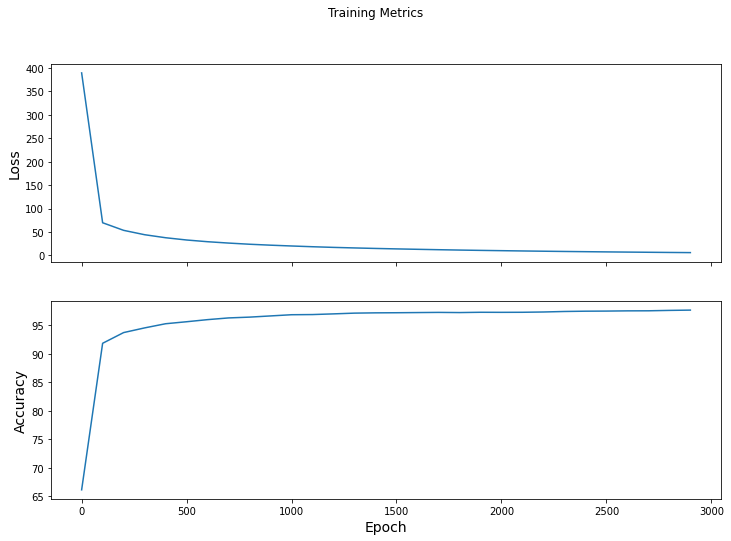

In [17]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

x_for_plot = np.arange(0, 3000, 100)

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(x_for_plot, loss_history)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(x_for_plot, accuracy_history)
plt.show()

In [18]:
# Вычислите точность обученной нейросети

accuracy_history[-1]

97.64999747276306

In [29]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

x_for_5 = x_test[:5]
y_for_5 = model(x_test[:5])
y2_for_5 = tf.argmax(y_for_5, axis=1).numpy()
print(y_test[:5] == y2_for_5)

[ True  True  True  True  True]


7


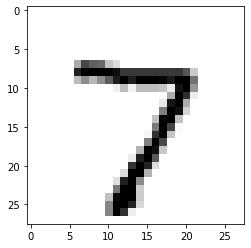

In [35]:
print(y2_for_5[0])
plt.imshow(x_for_5[0].reshape(28, 28), cmap='binary')

2


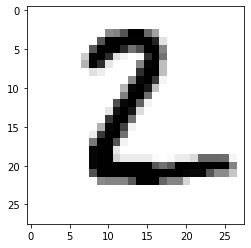

In [37]:
print(y2_for_5[1])
plt.imshow(x_for_5[1].reshape(28, 28), cmap='binary')

1


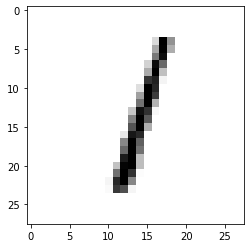

In [39]:
print(y2_for_5[2])
plt.imshow(x_for_5[2].reshape(28, 28), cmap='binary')

0


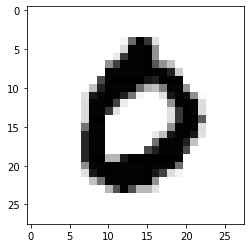

In [41]:
print(y2_for_5[3])
plt.imshow(x_for_5[3].reshape(28, 28), cmap='binary')

4


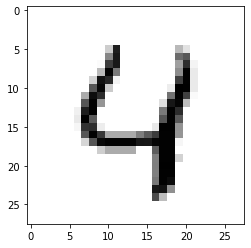

In [42]:
print(y2_for_5[4])
plt.imshow(x_for_5[4].reshape(28, 28), cmap='binary')